## Load Data

In [1]:
library(devtools)
# library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
# library(quantmod)
# library(xts)
# library(zoo)
library(gridExtra)
# library(tibble)
library(grid)
# library(future)
# library(future.apply)
# library(DescTools)
# library(rcompanion)
# library(tidyverse)
library(parallel)

source("forecast_research/finance/markets_functions.R")
load_all("forecast_research/vendor/hmmTMB")
remotes::install_local("/project/6004619/dcs01/forecast_research/vendor/hmmTMB")
options(warn = -1)

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Skipping install of 'hmmTMB' from a local remote, the SHA1 (1.1.0) has not changed since last install.
  Use `force = TRUE` to force installation



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index, Shipping_Futures



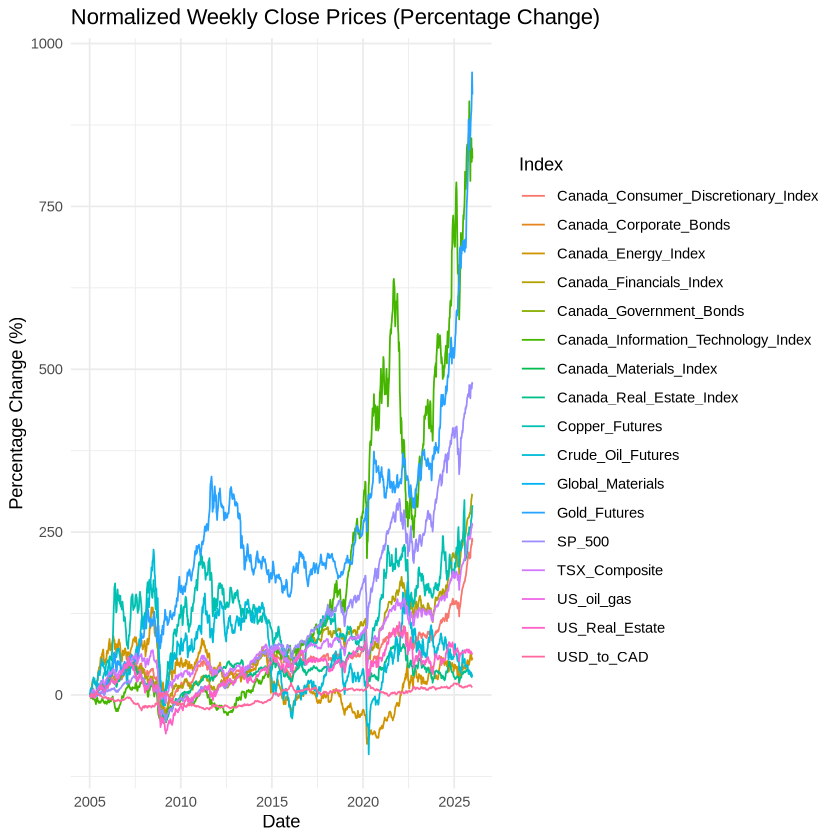

In [2]:
# close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- get_markets_data("2005-01-01", "2026-01-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )



In [31]:
buffer <- 3
forecast_horizon <- 10

close_data_log <- ln_transform(close_data)

test_start_date <- as.Date("2020-01-01")
test_start_index <- which.min(abs(as.numeric(close_data$Date - test_start_date)))
test_end_index <- nrow(close_data_log) - buffer
test_size <- test_end_index - test_start_index - forecast_horizon

train_end_index <- as.integer(test_start_index*0.8)
train_end_date <- close_data$Date[train_end_index]

valid_size <- test_start_index - train_end_index - forecast_horizon

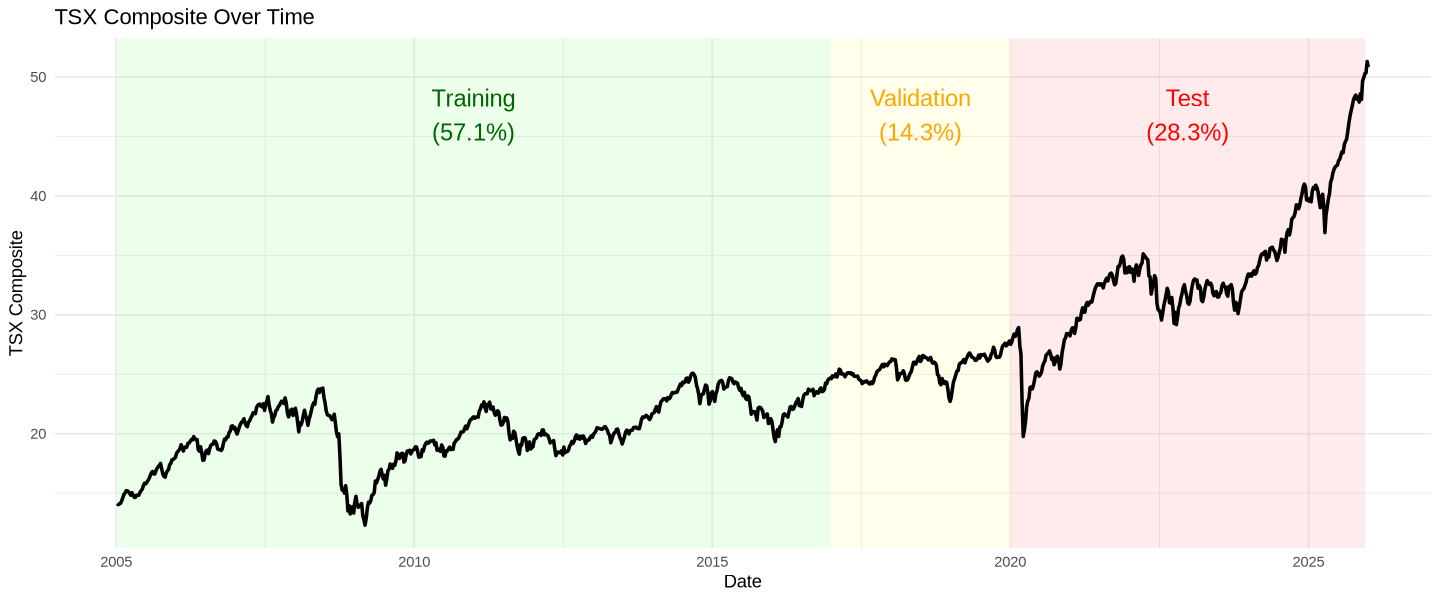

In [32]:
options(repr.plot.width=12, repr.plot.height=5)
ggplot(close_data, aes(x = Date, y = TSX_Composite)) +
  # Highlight train, validation, and test periods
  annotate("rect", xmin = min(close_data$Date), xmax = close_data$Date[train_end_index], ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "green") +
  annotate("rect", xmin = close_data$Date[train_end_index], xmax = close_data$Date[test_start_index], ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "yellow") +
  annotate("rect", xmin = close_data$Date[test_start_index], xmax = close_data$Date[test_end_index], ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "red") +
  geom_line(color = "black", size = 1) +
  labs(title = "TSX Composite Over Time", x = "Date", y = "TSX Composite") +
  theme_minimal() +
  annotate("text", 
           x = close_data$Date[round(train_end_index/2)], 
           y = Inf, 
           label = sprintf("Training\n(%.1f%%)", 100 * train_end_index / nrow(close_data)), 
           vjust = 2, size = 5, color = "darkgreen") +
  annotate("text", 
           x = close_data$Date[round((train_end_index + test_start_index)/2)], 
           y = Inf, 
           label = sprintf("Validation\n(%.1f%%)", 100 * (test_start_index - train_end_index) / nrow(close_data)), 
           vjust = 2, size = 5, color = "orange") +
  annotate("text", 
           x = close_data$Date[round((test_start_index + test_end_index)/2)], 
           y = Inf, 
           label = sprintf("Test\n(%.1f%%)", 100 * (test_end_index - test_start_index) / nrow(close_data)), 
           vjust = 2, size = 5, color = "red")


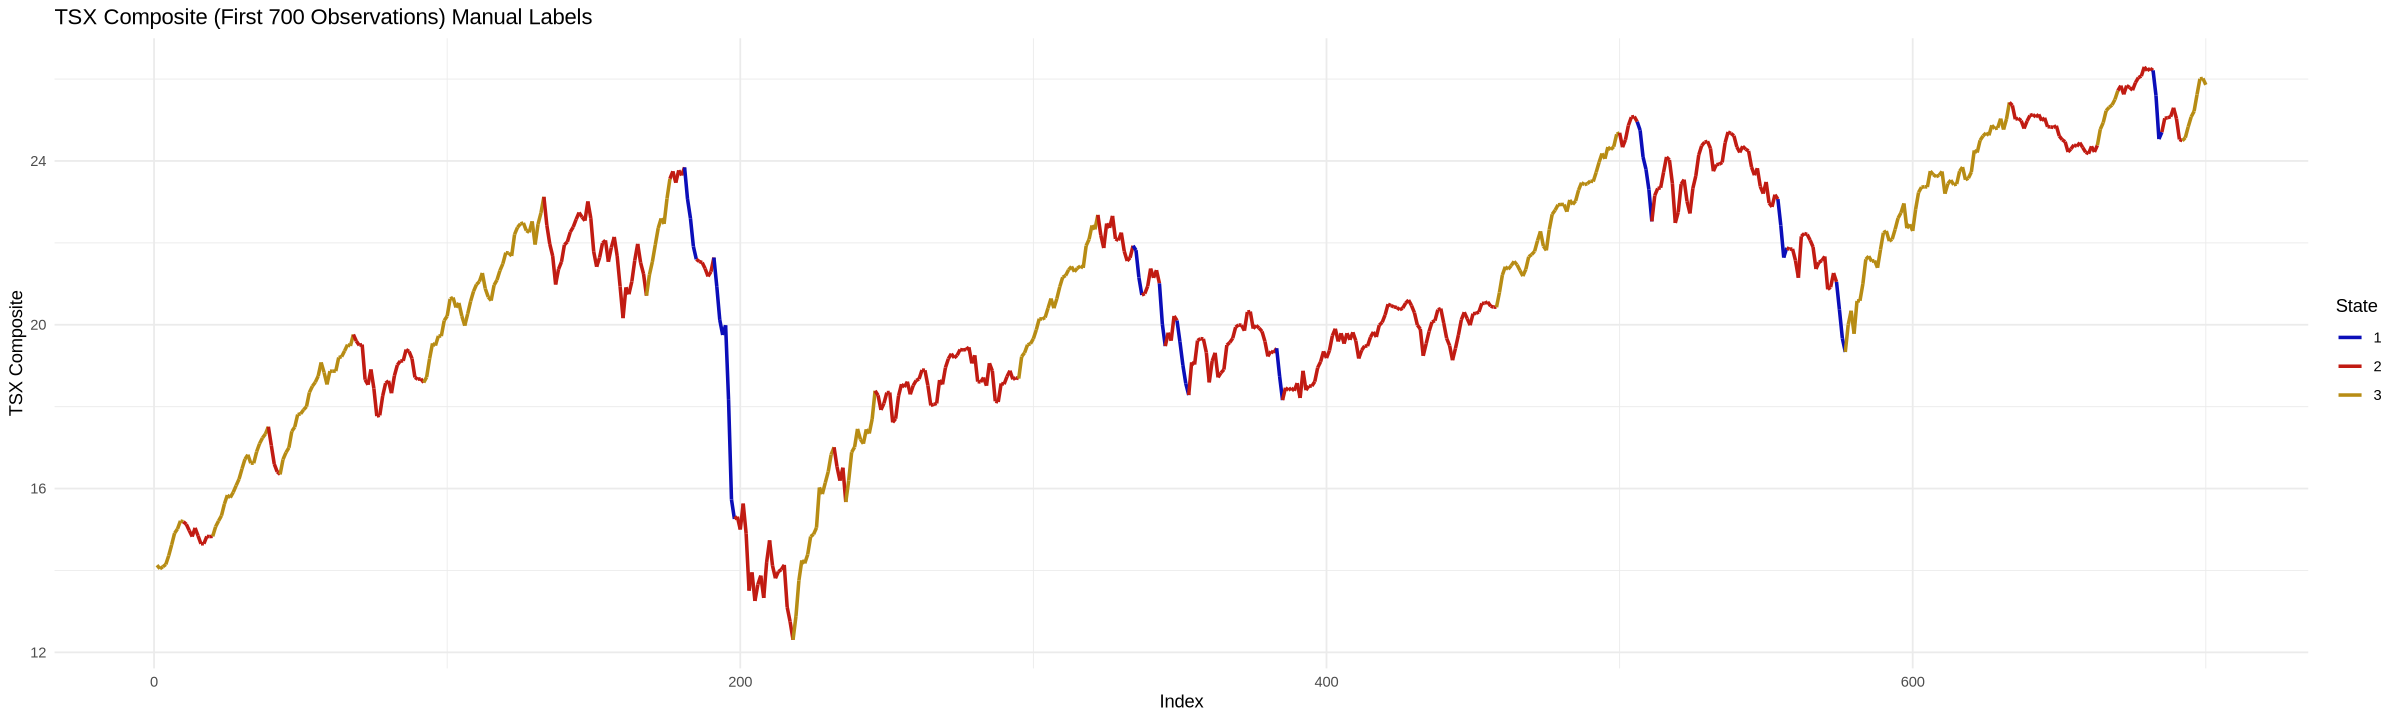

In [5]:
options(repr.plot.width=20, repr.plot.height=6)
state_array <- c(
  3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 35
  3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, # 70
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 105
  3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, # 140
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, # 175
  2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, # 210
  2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 245
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, # 280
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 315
  3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, # 350
  1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, # 385
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, # 420
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, # 455
  2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 490
  3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, # 525
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, # 560
  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 595
  3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, # 630
  3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, # 665
  3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3 # 700
)
# Create a data frame for plotting
plot_df <- data.frame(Index = 1:700, TSX_Composite = close_data$TSX_Composite[1:700], State = as.factor(state_array))
ggplot(plot_df, aes(Index, TSX_Composite, color = State, group = 1)) +
  geom_line(size = 1) +
  scale_color_manual(values = c("1" = "#0b0eb9", "2" = "#c11b12", "3" = "#b78c14")) +
  labs(title = "TSX Composite (First 700 Observations) Manual Labels", x = "Index", y = "TSX Composite", color = "State") +
  theme_minimal() + 
  xlim(1, 700)



### For each step of the test set, do a one step forecast and get the state probabilites

In [6]:
cross_entropy_loss <- function(y_true, y_hat) {
  # Add small epsilon to avoid log(0)
  epsilon <- 1e-12
  y_hat <- pmax(pmin(y_hat, 1 - epsilon), epsilon)
  array(-rowSums(y_true * log(y_hat)))
}

In [33]:
forecast_horizon <- 10
n_states <- 3
use_fixed_params <- FALSE
use_supervised_states <- FALSE
apply_winzorization <- FALSE
obs_name <- 'TSX_Composite'
model_name <- paste0(
  n_states, " state model",
  ifelse(use_fixed_params, ", Fixed Parameters", ""),
  ifelse(use_supervised_states, ", Supervised", ""),
  ifelse(apply_winzorization, ", Winzorized", "")
)

if (apply_winzorization) {
  close_data_log$TSX_Composite <- pmax(close_data_log$TSX_Composite, -0.055)
  close_data_log$TSX_Composite <- pmin(close_data_log$TSX_Composite, 0.055)
}

tsx_training_data <- close_data_log[1:train_end_index, , drop = FALSE]
if (use_supervised_states) {
  extended_state_array <- rep(NA, nrow(tsx_training_data))
  extended_state_array[1:min(length(state_array), nrow(tsx_training_data))] <- state_array[1:min(length(state_array), nrow(tsx_training_data))]
  tsx_training_data$state <- extended_state_array
}

if (n_states == 3 && use_fixed_params) {
  pars <- setNames(
    list(
      list(
        mean = c(-0.025, 0.00, 0.015),
        sd = c(0.03, 0.02, 0.02)
      )
    ),
    obs_name
  )
  fixpar <- list(obs = c(
      "TSX_Composite.mean.state1.(Intercept)" = NA,
      "TSX_Composite.mean.state2.(Intercept)" = NA,
      "TSX_Composite.mean.state3.(Intercept)" = NA
      )
  )
} else {
  pars <- setNames(
    list(
      list(
        mean = seq(-0.02, 0.01, length.out = n_states),
        sd = seq(0.1, 0.01, length.out = n_states)
      )
    ),
    obs_name
  )
  fixpar <- list()
}

hid_model <- MarkovChain$new(
  data = tsx_training_data,
  n_states = n_states,
  initial_state = "estimated"
)

obs_model <- Observation$new(
  data = tsx_training_data,
  n_states = n_states,
  dists = setNames(list("norm"), obs_name),
  par = pars
)
training_model <- HMM$new(hid = hid_model, obs = obs_model, fixpar = fixpar)
training_model$fit(silent = TRUE)

full_model <- fit_hmm(
  n_states = n_states,
  data = close_data_log,
  obs_name = "TSX_Composite",
  hid_formula = as.formula("~1"),
  horseshoe = FALSE,
  init = training_model
)
true_state_probs <- full_model$state_probs()

state_losses <- matrix(NA, nrow = test_size, ncol = forecast_horizon)
predictions <- array(NA, dim = c(test_size, forecast_horizon, n_states))
ground_truth <- array(NA, dim = c(test_size, forecast_horizon, n_states))

j <- 1
for (i in ((test_start_index+1):(test_end_index-forecast_horizon))) {
  fitting_data <- close_data_log[(i-100):i, , drop = FALSE]
  Y_true <- true_state_probs[(i+1):(i+forecast_horizon), , drop = FALSE]
  tsx_forecast <- fit_hmm(
    n_states = n_states,
    data = fitting_data,
    obs_name = "TSX_Composite",
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = training_model
  )
  forecaster <- Forecast$new(
    hmm = tsx_forecast,
    n = forecast_horizon,
    preset_eval_range = list(TSX_Composite = seq(from=-0.15, to=0.15, by=0.001))
  )
  Y_hat <- t(forecaster$hidden_state_forecast())
  predictions[j, , ] <- Y_hat
  ground_truth[j, , ] <- Y_true
  loss <- cross_entropy_loss(
    Y_true,
    Y_hat
  )
  state_losses[j, ] <- loss
  j <- j + 1
}

valid_loss <- matrix(NA, nrow = valid_size, ncol = forecast_horizon)

j <- 1
for (i in ((train_end_index+1):(test_start_index-forecast_horizon))) {
  fitting_data <- close_data_log[(i-100):(i-forecast_horizon), , drop = FALSE]
  Y_true <- true_state_probs[(i+1):(i+forecast_horizon), , drop = FALSE]
  tsx_forecast <- fit_hmm(
    n_states = n_states,
    data = fitting_data,
    obs_name = "TSX_Composite",
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = training_model
  )
  forecaster <- Forecast$new(
    hmm = tsx_forecast,
    n = forecast_horizon,
    preset_eval_range = list(TSX_Composite = seq(from=-0.15, to=0.15, by=0.001))
  )
  Y_hat <- t(forecaster$hidden_state_forecast())
  loss <- cross_entropy_loss(
    Y_true,
    Y_hat
  )
  valid_loss[j, ] <- loss
  j <- j + 1
}

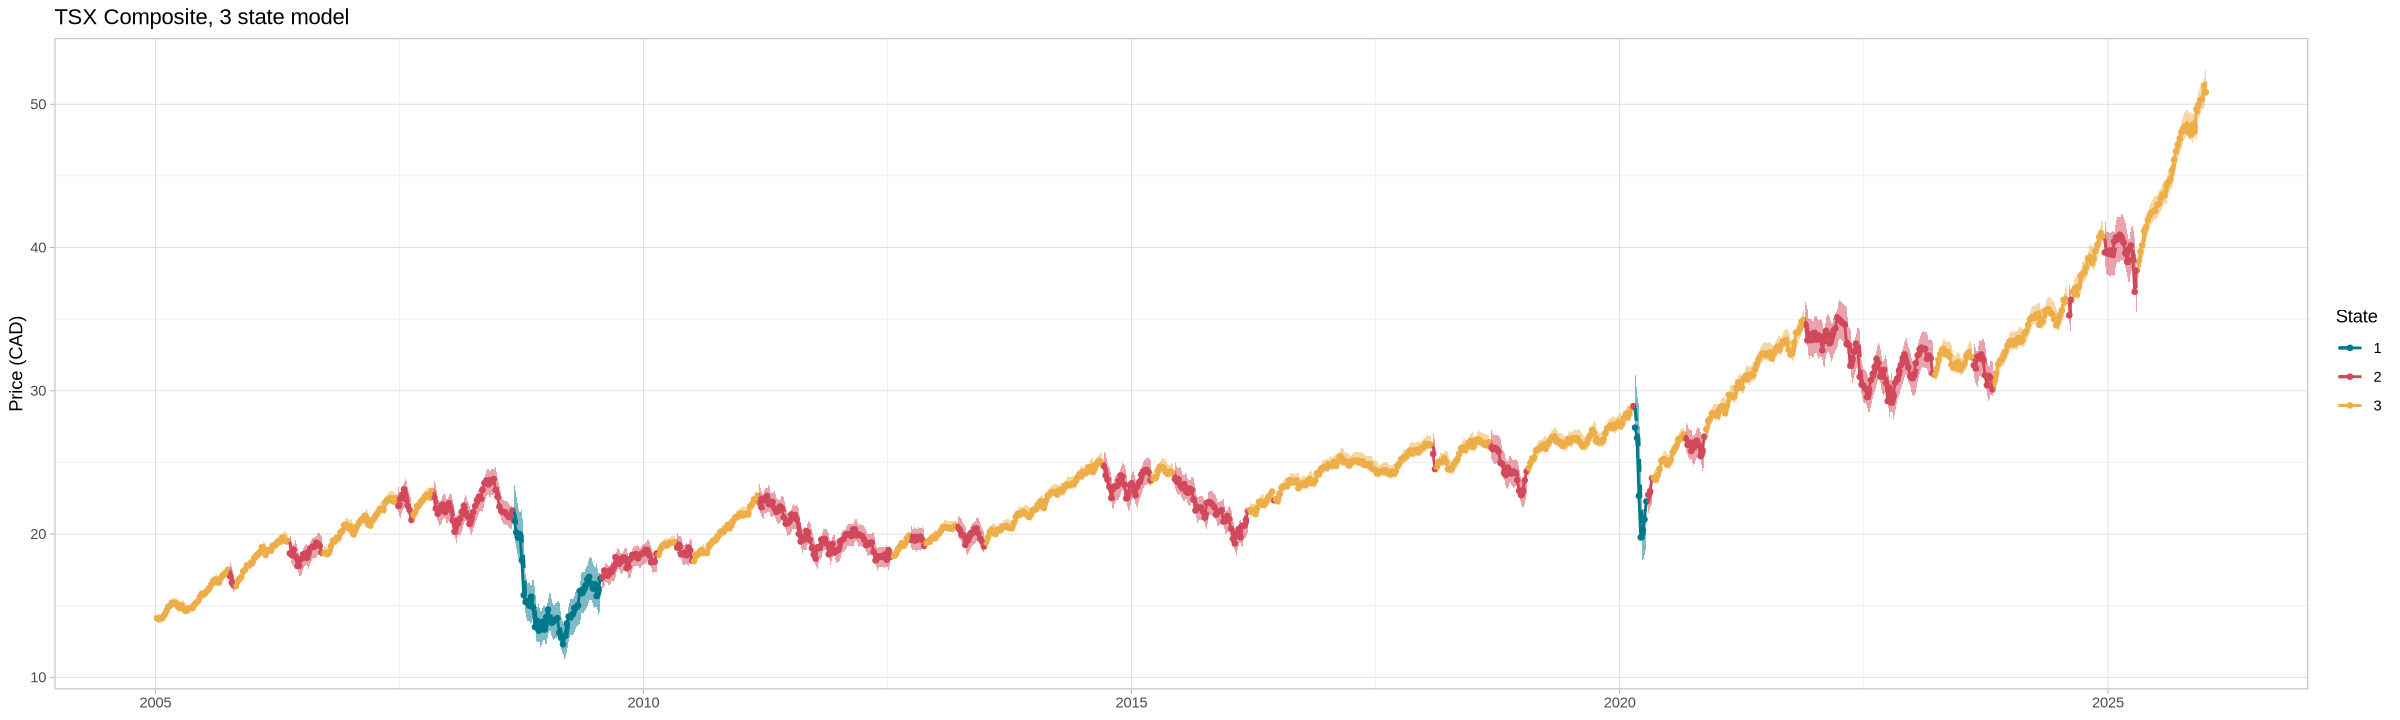

In [8]:
close_data_indexed <- close_data %>% tibble::column_to_rownames("Date")
tsx_state_3s <- prepare_tsx_state_data(close_data_indexed, full_model)
tsx_plot_3s  <- plot_tsx_state_series(tsx_state_3s, show = "both") +
  ggtitle(paste0("TSX Composite, ", model_name))
#   xlim(as.Date("2005-01-01"), as.Date("2010-01-01"))
tsx_plot_3s

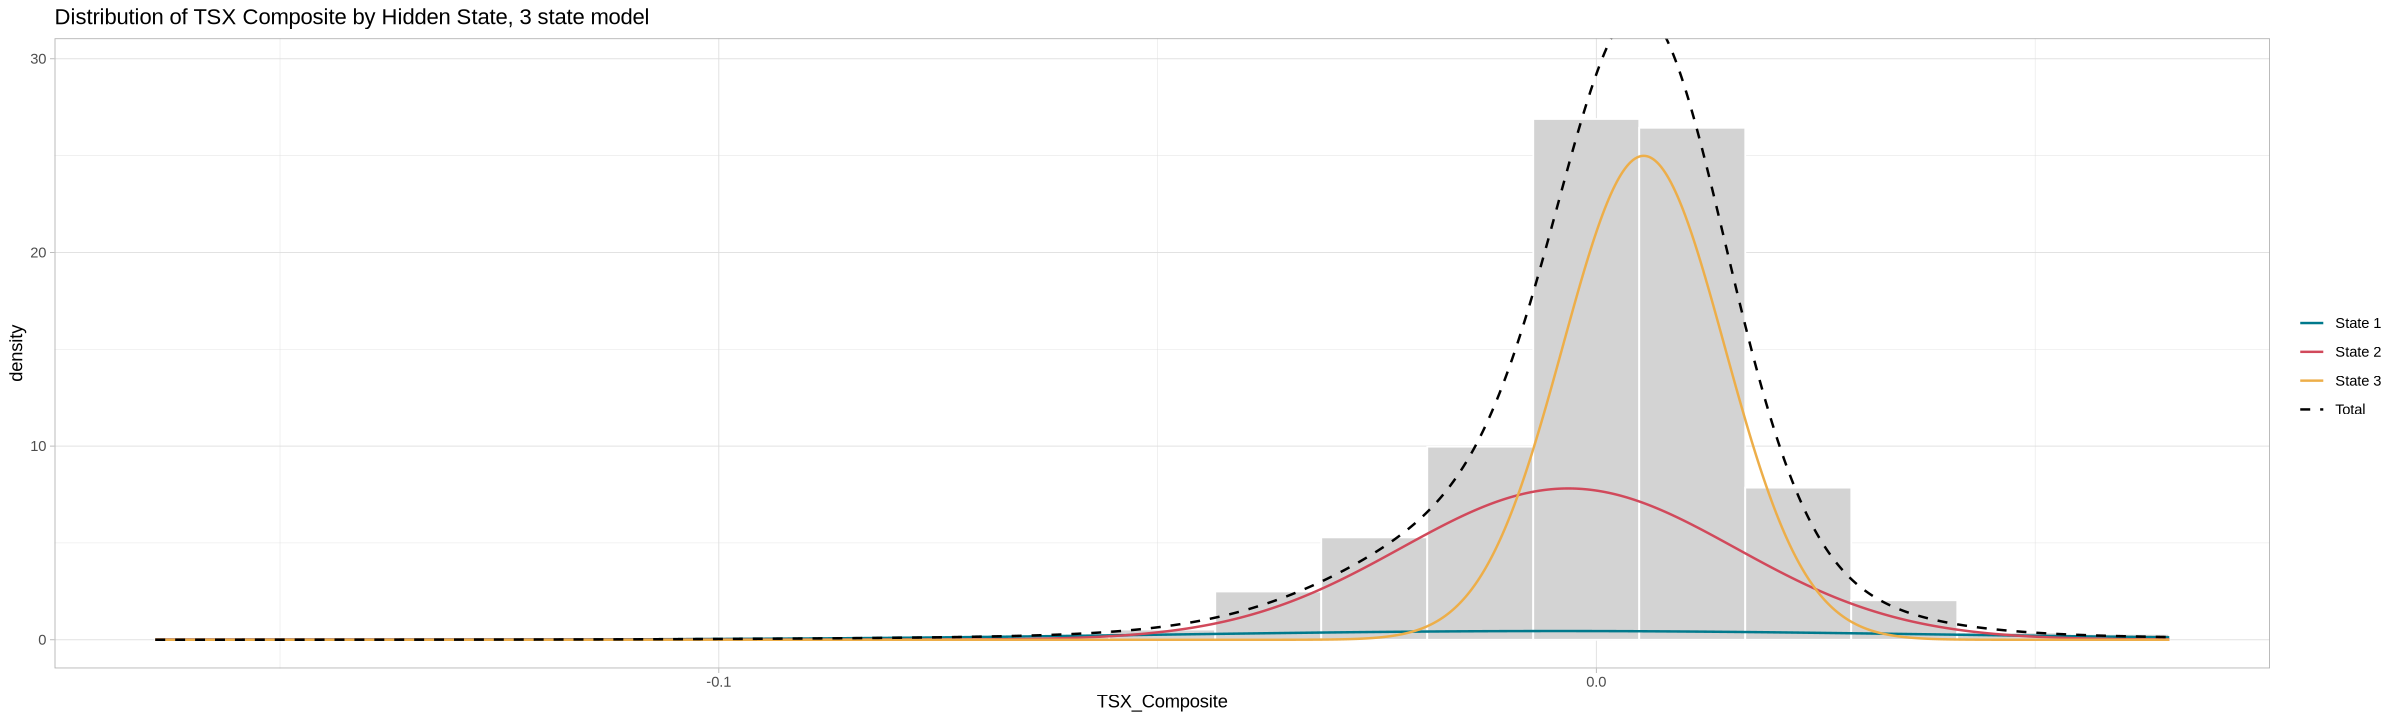

In [9]:
full_model$plot_dist('TSX_Composite') +
  ggtitle(paste0("Distribution of TSX Composite by Hidden State, ", model_name))

In [10]:
full_model$hid()$tpm()

, , 1

             state 1    state 2      state 3
state 1 9.761346e-01 0.02386540 4.003784e-14
state 2 4.028604e-03 0.89370514 1.022663e-01
state 3 2.266496e-09 0.09334226 9.066577e-01

In [11]:
states <- full_model$states()
state_factor <- as.factor(states)
state_table <- table(state_factor)
state_percent <- prop.table(state_table) * 100

# Calculate durations
rle_states <- rle(states)
durations <- data.frame(state = rle_states$values, length = rle_states$lengths)

summary_df <- durations %>%
  group_by(state) %>%
  summarise(
    periods = n(),
    avg_duration = mean(length),
    min_duration = min(length),
    max_duration = max(length)
  )

summary_df$state_percent <- as.numeric(state_percent)
summary_df

state,periods,avg_duration,min_duration,max_duration,state_percent
<int>,<int>,<dbl>,<int>,<int>,<dbl>
1,2,27.00000,7,47,4.927007
2,21,19.47619,1,71,37.317518
3,20,31.65000,10,84,57.755474


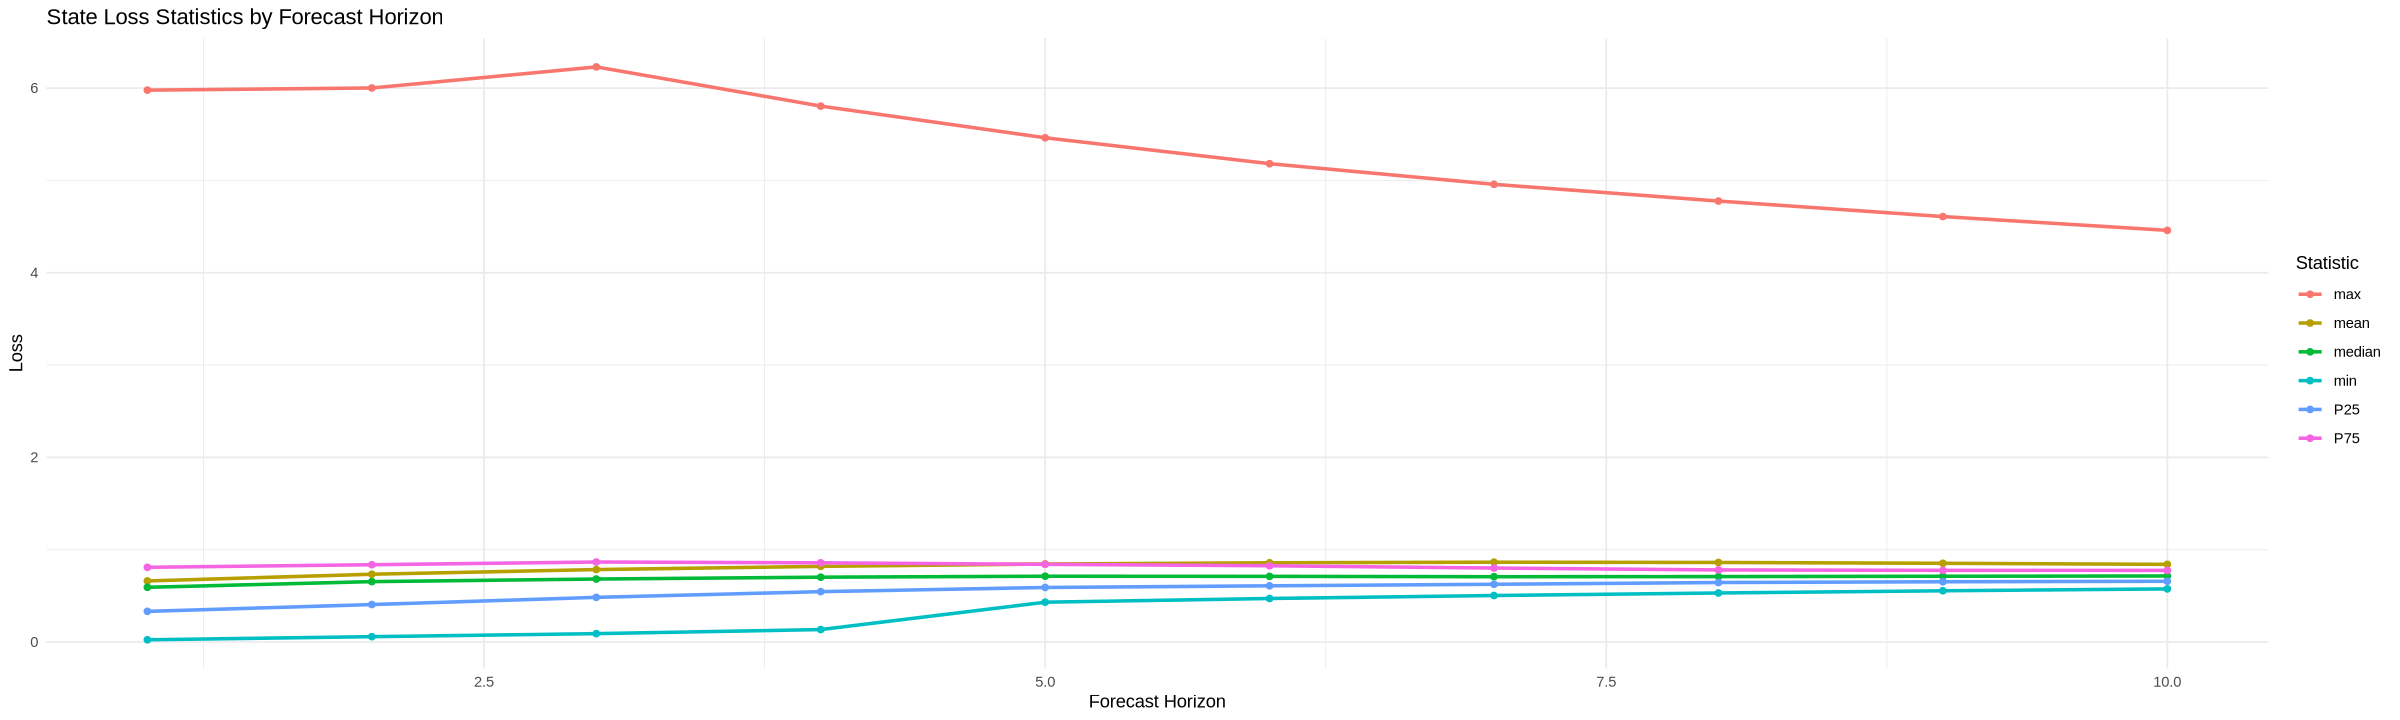

In [12]:
# Compute statistics for each forecast horizon (column)
stats_df <- data.frame(
  Horizon = 1:ncol(state_losses),
  mean = apply(state_losses, 2, mean, na.rm = TRUE),
  median = apply(state_losses, 2, median, na.rm = TRUE),
  P25 = apply(state_losses, 2, quantile, probs = 0.25, na.rm = TRUE),
  P75 = apply(state_losses, 2, quantile, probs = 0.75, na.rm = TRUE),
  max = apply(state_losses, 2, max, na.rm = TRUE),
  min = apply(state_losses, 2, min, na.rm = TRUE)
)

# Reshape for plotting
library(tidyr)
stats_long <- pivot_longer(stats_df, cols = -Horizon, names_to = "Statistic", values_to = "Value")

# Plot
library(ggplot2)
ggplot(stats_long, aes(x = Horizon, y = Value, color = Statistic)) +
  geom_line(size = 1) +
  geom_point() +
  labs(title = "State Loss Statistics by Forecast Horizon",
       x = "Forecast Horizon",
       y = "Loss") +
  theme_minimal()

In [13]:
stats_df

Horizon,mean,median,P25,P75,max,min
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6616478,0.5926843,0.3319506,0.8091674,5.977999,0.02415479
2,0.7342270,0.6541474,0.4057958,0.8370713,6.001657,0.05778721
3,0.7846184,0.6820042,0.4836810,0.8663040,6.229743,0.09061618
4,0.8193689,0.7021893,0.5455005,0.8576911,5.805130,0.13485374
5,0.8446996,0.7124275,0.5907291,0.8412781,5.461919,0.43122549
6,0.8582164,0.7110198,0.6085951,0.8259713,5.181384,0.47136534
7,0.8644418,0.7072314,0.6252695,0.8010566,4.957558,0.50345143
8,0.8615521,0.7085940,0.6441821,0.7807668,4.776447,0.53094123
9,0.8526009,0.7120633,0.6524656,0.7761029,4.608543,0.55493156


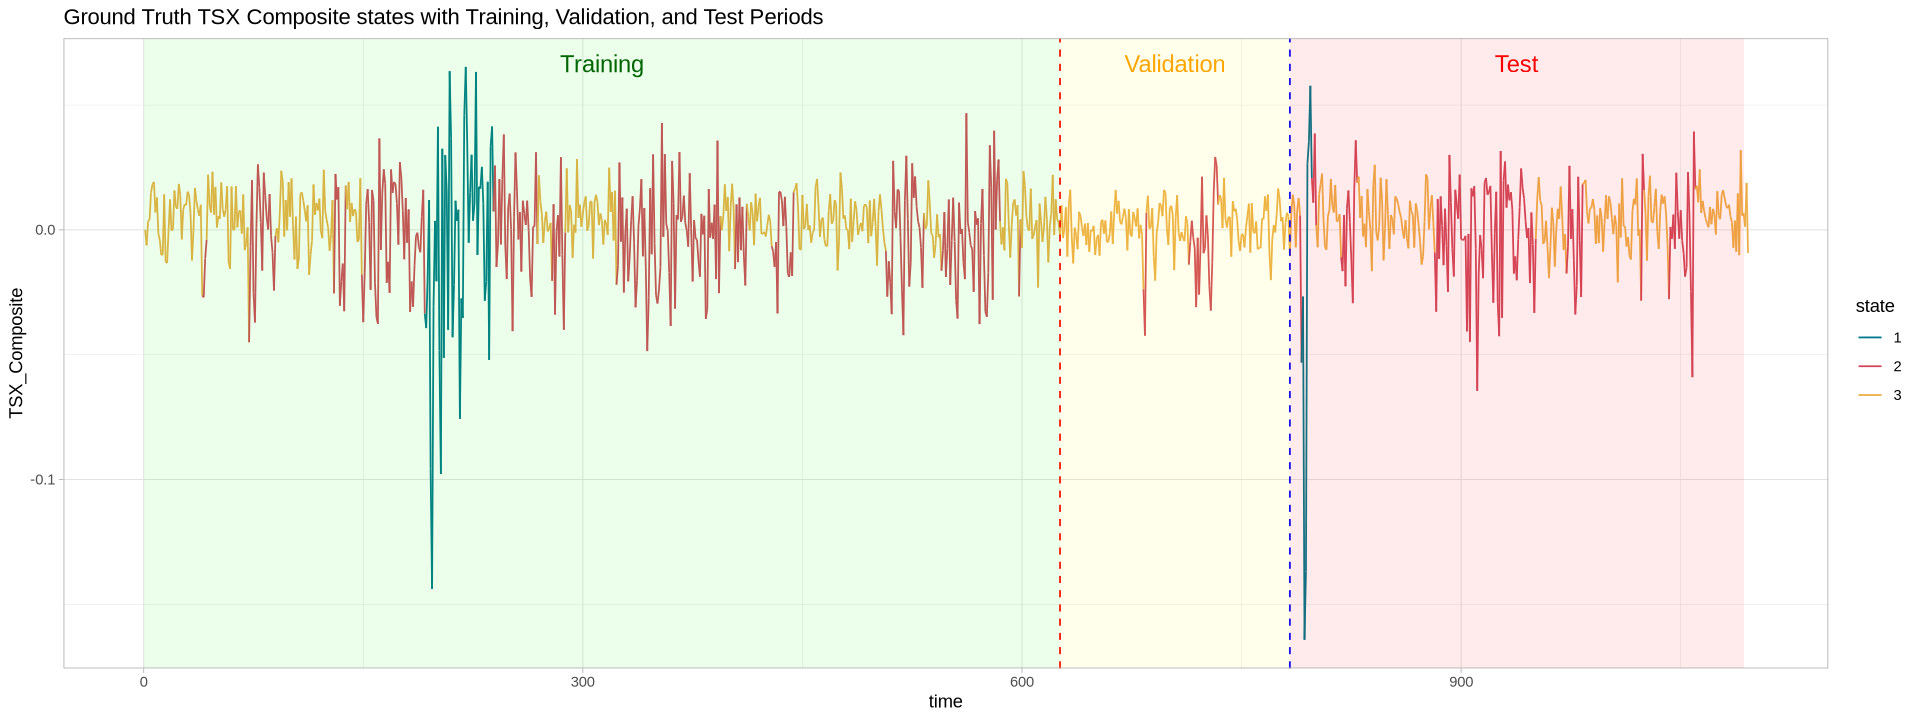

In [14]:
options(repr.plot.width=16, repr.plot.height=6)

p <- full_model$plot_ts("TSX_Composite")

p + 
  geom_vline(xintercept = train_end_index, linetype = "dashed", color = "red") +
  geom_vline(xintercept = test_start_index, linetype = "dashed", color = "blue") +
  annotate("rect", xmin = 0, xmax = train_end_index, ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "green") +
  annotate("rect", xmin = train_end_index, xmax = test_start_index, ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "yellow") +
  annotate("rect", xmin = test_start_index, xmax = test_end_index, ymin = -Inf, ymax = Inf, alpha = 0.08, fill = "red") +
  annotate("text", x = train_end_index/2, y = Inf, label = "Training", vjust = 2, size = 5, color = "darkgreen") +
  annotate("text", x = (train_end_index + test_start_index)/2, y = Inf, label = "Validation", vjust = 2, size = 5, color = "orange") +
  annotate("text", x = (test_start_index + test_end_index)/2, y = Inf, label = "Test", vjust = 2, size = 5, color = "red") +
  ggtitle("Ground Truth TSX Composite states with Training, Validation, and Test Periods")

## Create the training, validation and test sets needed by LSTM model

In [15]:
# Train base models for covariate columns
covariates <- c("TSX_Composite", "Crude_Oil_Futures", "Gold_Futures", "Copper_Futures",  "SP_500")
lookback <- 10
hmm_lookback <- 40

trained_models <- list(TSX_composite = training_model)
for (covariate in setdiff(covariates, "TSX_Composite")) {
  # Exclude TSX Composite to avoid risk of states being label swaped.
  hmm_model <- fit_hmm(
    n_states = n_states,
    data = close_data_log[1:train_end_index, , drop = FALSE],
    obs_name = covariate,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = NULL
  )
  trained_models[[covariate]] <- hmm_model
}

# Define the function to prepare X and Y lists for a given index range
prepare_dataset <- function(start_idx, end_idx) {
  num_samples <- end_idx - start_idx + 1 - forecast_horizon
  n_cov <- length(covariates)
  features <- n_cov * (n_states + 1) # n_states + 1 log return per covariate

  X <- array(NA, dim = c(num_samples, lookback, features))
  Y <- array(NA, dim = c(num_samples, forecast_horizon, n_states))

  j <- 1
  for (i in start_idx:(end_idx-forecast_horizon)) {
    fitting_data <- close_data_log[(i - hmm_lookback):i, , drop = FALSE]
    training_data <- array(NA, dim = c(lookback, 0))
    for (covariate in covariates) {
      cov_model <- fit_hmm(
        n_states = n_states,
        data = fitting_data,
        obs_name = covariate,
        hid_formula = as.formula("~1"),
        horseshoe = FALSE,
        init = trained_models[[covariate]]
      )
      states <- tail(cov_model$state_probs(), lookback)
      colnames(states) <- paste0(covariate, "_", 1:n_states)
      log_data <- tail(fitting_data[, covariate, drop = FALSE], lookback)
      training_data <- cbind(training_data, as.matrix(states), as.matrix(log_data))
    }
    Y_data <- true_state_probs[(i + 1):(i + forecast_horizon), , drop = FALSE]
    X[j, , ] <- training_data
    Y[j, , ] <- Y_data
    j <- j + 1
  }
  return(list(X = X, Y = Y))
}

# Call the function for training data
train_data <- prepare_dataset(hmm_lookback, train_end_index)
X_train <- train_data$X
Y_train <- train_data$Y

# Call the function for validation data
valid_data <- prepare_dataset(train_end_index + 1, test_start_index)
X_valid <- valid_data$X
Y_valid <- valid_data$Y

# Call the function for test data
test_data <- prepare_dataset(test_start_index + 1, test_end_index)
X_test <- test_data$X
Y_test <- test_data$Y

In [16]:
folder_name <- model_name %>%
  gsub(", ", "_", .) %>%
  gsub(" ", "_", .) %>%
  tolower()
if (!dir.exists(folder_name)) {
  dir.create(folder_name)
}

tpm <- full_model$hid()$tpm()

In [36]:
write.csv(close_data_log, paste0(folder_name, "/close_data_log.csv"), row.names = FALSE)
write.csv(tpm, paste0(folder_name, "/transition_matrix.csv"), row.names = TRUE)
saveRDS(X_train, paste0(folder_name, "/lstm_X_train.rds"))
saveRDS(Y_train, paste0(folder_name, "/lstm_Y_train.rds"))
saveRDS(X_valid, paste0(folder_name, "/lstm_X_valid.rds"))
saveRDS(Y_valid, paste0(folder_name, "/lstm_Y_valid.rds"))
saveRDS(X_test, paste0(folder_name, "/lstm_X_test.rds"))
saveRDS(Y_test, paste0(folder_name, "/lstm_Y_test.rds"))
saveRDS(stats_df, paste0(folder_name, "/hmm_stats_df.rds"))
saveRDS(state_losses, paste0(folder_name, "/hmm_state_losses.rds"))
saveRDS(predictions, paste0(folder_name, "/hmm_predictions.rds"))
saveRDS(ground_truth, paste0(folder_name, "/hmm_ground_truth.rds"))
saveRDS(valid_loss, paste0(folder_name, "/hmm_valid_loss.rds"))

In [18]:
dim(ground_truth)

[1] 300  10   3

In [19]:
dim(Y_test)

[1] 300  10   3

In [24]:
dim(state_losses)

[1] 300  10

In [20]:
ground_truth[10, , ] == Y_test[10, , ]

TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE
TRUE,TRUE,TRUE


In [34]:
dim(X_valid)

[1] 147  10  20

In [35]:
dim(valid_loss)

[1] 147  10